In [3]:
import os, sys, glob
import pandas as pd
import numpy as np
import cv2
from keras.models import load_model
sys.path.append('ml-models/sputum_detector/')
sys.path.append('ml-models/bacili_detector/')
from sputum_detection_model import SputumDetectionModel
from src.dataset import BaciliDataset

In [4]:
from keras.models import load_model
model_final = load_model('ml-models/sputum_detector/models/rcnn_MNasNet_2.h5')
model = SputumDetectionModel(model_final, chunk_size=80, stride=40, verbose=True)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-08-19 01:29:27.307489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-19 01:29:27.307720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# fine-tune the model on the test set
test_imgs = glob.glob('data/tuberculosis-phonecamera/*.jpg')
tst_arrs = []
for img in test_imgs:
    im = cv2.imread(img)
    # coord, im_chunks = model.preprocess_img(im)
    # tst_arrs.append(im_chunks)
    break

In [6]:
img_path = test_imgs[0]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
out, chunks = model.predict(img)
print(sum(out[:,0]>0.5), "chunks detected")
print("chunks has shape", chunks.shape)
new_img=model.visualize_prediction(img, out, chunks, asarray=False)

2023-08-19 01:29:33,883 - sputum_detection_model.predict - INFO - Predicting bounding boxes
2023-08-19 01:29:35.059210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 8s 125ms/step


2023-08-19 01:29:42,405 - sputum_detection_model.predict - INFO - No bounding boxes were found


ValueError: not enough values to unpack (expected 2, got 0)

In [5]:
from ultralytics import YOLO, yolo

# Initialize YOLO v8s
yolo = YOLO('yolov8n.pt')

# yolo.train(

In [12]:
import torch
from torch.utils.collect_env import main
print(torch.backends.mps.is_available())
main()

True
PyTorch version: 2.0.0
Is debug build: False
CUDA used to build PyTorch: None
ROCM used to build PyTorch: N/A

OS: macOS 13.0 (arm64)
GCC version: Could not collect
Clang version: 14.0.0 (clang-1400.0.29.202)
CMake version: version 3.23.4
Libc version: N/A

Python version: 3.8.16 | packaged by conda-forge | (default, Feb  1 2023, 16:01:13)  [Clang 14.0.6 ] (64-bit runtime)
Python platform: macOS-13.0-arm64-arm-64bit
Is CUDA available: False
CUDA runtime version: No CUDA
CUDA_MODULE_LOADING set to: N/A
GPU models and configuration: No CUDA
Nvidia driver version: No CUDA
cuDNN version: No CUDA
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

CPU:
Apple M1 Pro

Versions of relevant libraries:
[pip3] mypy-extensions==1.0.0
[pip3] numpy==1.24.2
[pip3] torch==2.0.0
[pip3] torchvision==0.15.1
[conda] numpy                     1.24.2                   pypi_0    pypi
[conda] torch                     2.0.0                    pypi_0    pypi
[conda] torchvisio

In [128]:
import numpy as np
import cv2
from sklearn.cluster import KMeans

# Function for region growing
def region_growing(img, seed):
    # parameters
    height, width = img.shape
    visited = np.zeros_like(img, dtype=np.uint8)
    stack = []
    stack.append((seed[0], seed[1]))
    
    while len(stack) > 0:
        pixel = stack.pop()
        x = pixel[0]
        y = pixel[1]

        if x < 1 or y < 1 or x >= height - 1 or y >= width - 1:
            continue

        if visited[x, y] == 1:
            continue

        visited[x, y] = 1

        # check neighbours
        if img[x, y] == 255:
            if img[x - 1, y - 1] == 255:
                stack.append((x - 1, y - 1))
            if img[x - 1, y] == 255:
                stack.append((x - 1, y))
            if img[x - 1, y + 1] == 255:
                stack.append((x - 1, y + 1))
            if img[x, y - 1] == 255:
                stack.append((x, y - 1))
            if img[x, y + 1] == 255:
                stack.append((x, y + 1))
            if img[x + 1, y - 1] == 255:
                stack.append((x + 1, y - 1))
            if img[x + 1, y] == 255:
                stack.append((x + 1, y))
            if img[x + 1, y + 1] == 255:
                stack.append((x + 1, y + 1))

    return visited

def preprocess_image(image: np.ndarray, th=0.4) -> np.ndarray:
    # Removing pixels not related to red color using a CY-based color filter
    image = image.astype(np.float32)
    r,g,b = cv2.split(image)
    cy = (r - ((g + b) / 2)) / (np.sqrt((r ** 2) + (g ** 2) + (b ** 2)))

    red_pixels = cy > th # Threshold defined experimentally
    image[~red_pixels] = [0, 0, 0]
    image = image.astype(np.uint8)

    # K-means clustering
    img2 = image.reshape((-1,3))
    kmeans = KMeans(n_clusters=2, random_state=0).fit(img2)
    segmented = kmeans.cluster_centers_[kmeans.labels_]

    # Reshaping back to the original image dimensions
    segmented_image = segmented.reshape(image.shape).astype(np.uint8)

    gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

    # Applying a 5x5 median filter to remove small artifacts and smooth the segmented region
    median_filtered = cv2.medianBlur(gray, 5)
    _, binary = cv2.threshold(median_filtered, 1, 255, cv2.THRESH_BINARY)

    # Applying region growing to label and identify the region size
    seed = (0, 0) # Start from the top-left pixel
    labeled_img = region_growing(binary, seed)

    # Removing regions with size less than 50 pixels or larger than 800 pixels
    num_components, component_img = cv2.connectedComponents(labeled_img)
    for i in range(1, num_components):
        if np.sum(component_img == i) < 50 or np.sum(component_img == i) > 800:
            image[component_img == i] = 0

    return image #segmented_image

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def mask_filter(img:np.ndarray) -> np.ndarray:
    """
    preprocess image only keeping red-pink colored pixels
    and applying erosion and dilation
    """
    # First stage: convert to hsv and keep only red-pink pixels
    # convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # hsv_blurred = cv2.GaussianBlur(hsv, (7, 7), 0)
    blue_green_mask = cv2.inRange(
        hsv, np.array([45, 0, 0]), np.array([115, 255, 255])
    )
    # all black or all white
    white_mask = cv2.inRange(
        hsv, np.array([0, 0, 200]), np.array([255, 255, 255])
    )
    black_mask = cv2.inRange(
        hsv, np.array([0, 0, 0]), np.array([255, 255, 50])
    )
    mask = blue_green_mask + white_mask + black_mask
    # slice the red
    imask = mask == 0
    return imask

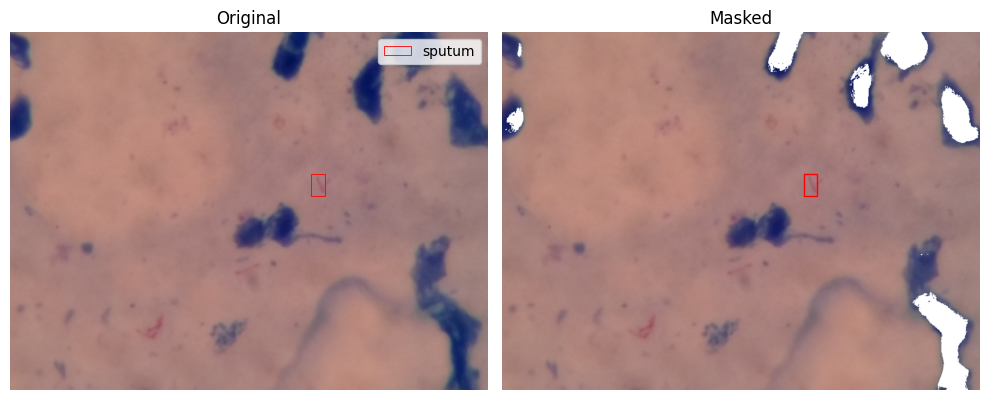

In [9]:
import matplotlib.pyplot as plt
import os, dotenv
from PIL import Image
from annotations.object_detection import ImageForObjectDetection
from annotations import db

dotenv.load_dotenv(dotenv.find_dotenv())

fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes = axes.flatten()
# im_original = Image.open(test_imgs[2])
ax = axes[0]
with db.get_session(os.environ.get('DATABASE_URI')) as session:
    imod = ImageForObjectDetection.from_db(
        session.query(db.Artifact).filter(db.Artifact.id == 192).one()
    )
    imod.display(ax=ax)
    im_original = imod.pil()
    ax.set_title('Original'); ax.axis('off')

red_mask = mask_filter(np.array(im_original))
masked_img = np.array(im_original.copy()) #* red_mask.reshape(*red_mask.shape, 1)
# color mask in white
masked_img[~red_mask] = 255
axes[1].imshow(masked_img)
axes[1].set_title('Masked'); axes[1].axis('off')
for rect in imod.rects:
    rect.plot(ax=axes[1], color='r')

fig.tight_layout()

(1271, 4)
(1271, 4)


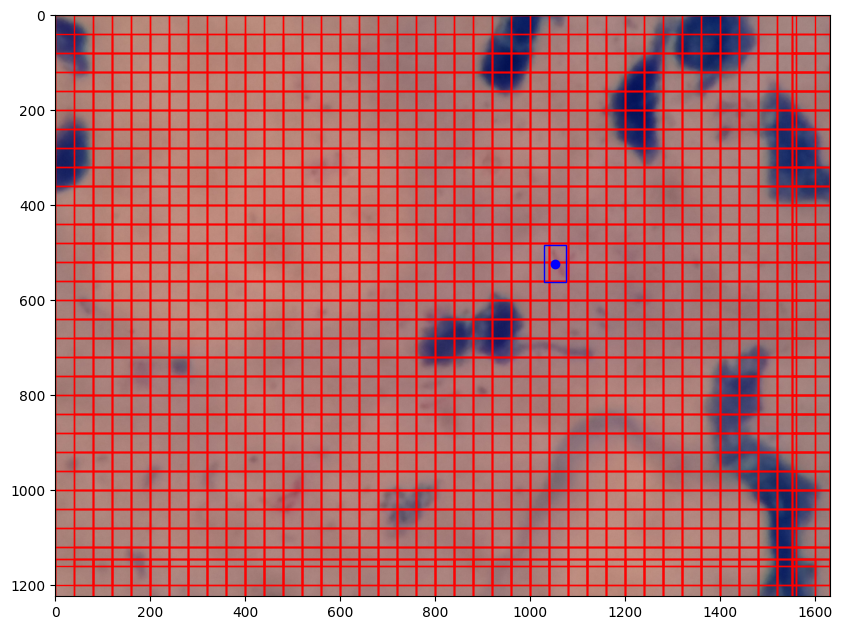

In [14]:
from matplotlib import pyplot as plt
from matplotlib import patches
from annotations.object_detection.rect import Rect
from src.dataset.preprocessing import mask_filter, tile_coords

# get candidate rects
img = np.array(im_original)
candidate_rects, nr, nc = tile_coords(1632, 1224, 80, 40)
print(candidate_rects.shape)
# only keep candidate rects that are within the mask
mask = mask_filter(img)
masked_img = img * mask.reshape(*mask.shape, 1)
candidate_rects = np.array([
    (x1, y1, x2, y2)
    for x1, y1, x2, y2 in candidate_rects
    if np.sum(masked_img[x1:x2, y1:y2]==0) < (80*80*3-60)
])
print(candidate_rects.shape)
# visualize candidate rects
fig, ax = plt.subplots(figsize=(10, 10))
for x1, y1, x2, y2 in candidate_rects:
    ax.add_patch(
        patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
        )
    )
for rect in imod.rects:
    rect.plot(ax, color="b")
centers = [rect.center for rect in imod.rects]
ax.plot([center[0] for center in centers], [center[1] for center in centers], "bo")
ax.imshow(img)
plt.show()

(1052.5, 523.0)


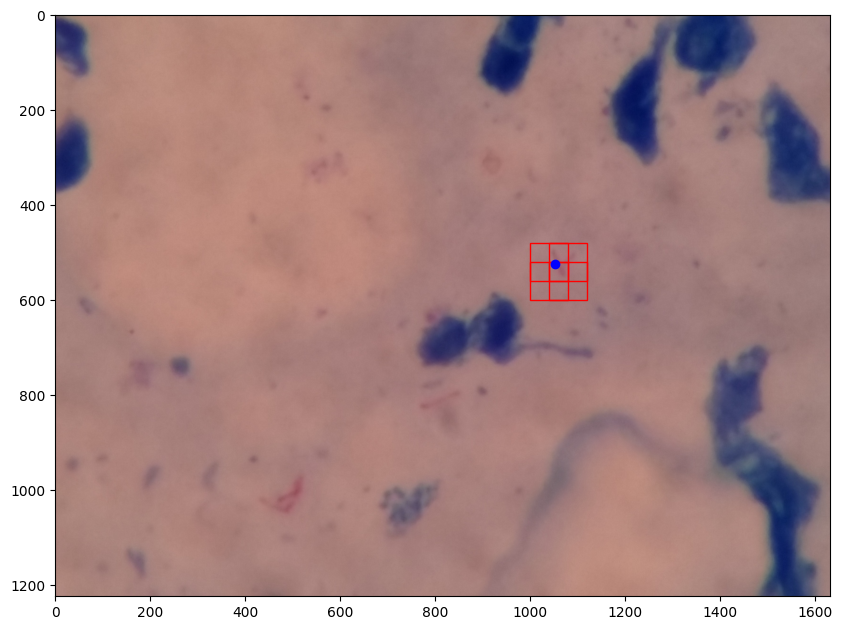

In [15]:
r3 = imod.rects[-1]
# print(r1.intersects(r2))
true_rect = np.array(r3.xyxy)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

# check if center of r3 is inside any of the candidate boxes
center = r3.center
print(center)
ax.plot(center[0], center[1], 'bo')
overlap = (candidate_rects[..., 0] < center[1]) & \
            (candidate_rects[..., 1] < center[0]) & \
                (candidate_rects[..., 2] > center[1]) & \
                    (candidate_rects[..., 3] > center[0])
for r in candidate_rects[overlap]:
    Rect.from_bbox([r[1], r[0], r[3], r[2]]).plot(ax, color='r')
# r3.plot(ax, color='b')

In [16]:
import pandas as pd
from annotations.object_detection.rect import Rect, Rects
from sqlalchemy.orm import joinedload

# count number of rects and number of filtered candidate rects for each image
th = 80*80*3-60
filtered_rects_count = []
imgs = []

with db.get_session(os.environ.get('DATABASE_URI')) as session:
    artifacts = session.query(
        db.Artifact
    ).join(
        db.ArtifactTag
    ).where(
        db.ArtifactTag.tag.in_(["train", "test"])
    ).options(
        joinedload(db.Artifact.annotations)
    ).options(
        joinedload(db.Artifact.annotations)
        .joinedload(db.Annotation.properties)
    ).all()

In [77]:
tiled_coords, nr, nc = tile_coords(1632, 1224, 80, 40)

data_dicts = []
for i, art in enumerate(artifacts):
    if i==0:
        continue
    if len(art.annotations)==0:
        continue
    imod = ImageForObjectDetection.from_db(art)
    img = imod.numpy()
    # imgs.append(img)
    mask = mask_filter(img)
    masked_img = img * mask.reshape(*mask.shape, 1)
    candidate_rects = np.array([
        (x1, y1, x2, y2)
        for x1, y1, x2, y2 in tiled_coords
        if np.sum(masked_img[x1:x2, y1:y2]==0) < th
    ])
    # how many missing true rects?
    centers = [r.center for r in imod.rects]
    overlaps = np.array([
        ((candidate_rects[..., 0] < center[0]) & \
        (candidate_rects[..., 1] < center[1]) & \
            (candidate_rects[..., 2] > center[0]) & \
                (candidate_rects[..., 3] > center[1]))
        for center in centers
    ])
    missing_count = sum(overlaps.sum(axis=1)==0)
    if overlaps.shape[0]==1:
        overlaps = overlaps.squeeze()
    else:
        overlaps = overlaps.any(axis=0)
    labels = np.zeros(len(candidate_rects))
    labels[overlaps] = 1 # 1 for bacili, 0 for background
    img_data_dict = {
        "image": imod.pil(),
        "image_id": imod.artifact.id,
        "image_uri": imod.uri,
        "num_candidate_boxes": nr*nc,
        "num_filtered_boxes": len(candidate_rects),
        "num_true": len(imod.rects),
        "num_missing_true": missing_count,
        "boxes": candidate_rects,
        "labels": labels.tolist()
    }
    data_dicts.append(img_data_dict)
    # filtered_rects_count.append(img_rects_count)

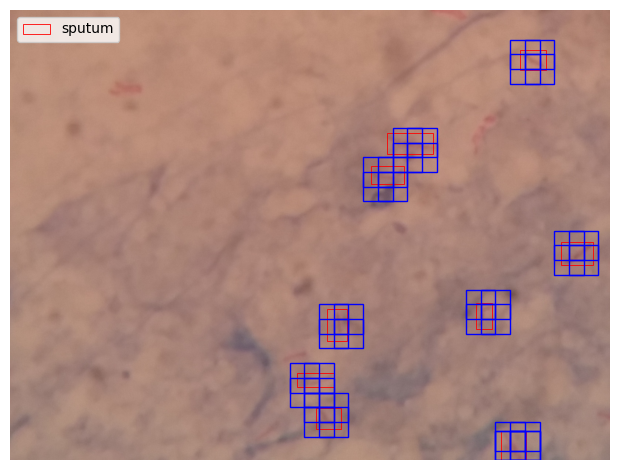

In [76]:
from matplotlib.patches import Rectangle

ax = imod.display()
for rect in candidate_rects[overlaps]:
    ax.add_patch(Rectangle(rect[:2], *(rect[2:]-rect[:2]), fill=False, color="b"))

In [78]:
df = pd.DataFrame(data_dicts)\
    .assign(difference_rects=lambda df: df.num_candidate_boxes-df.num_filtered_boxes)
print(df.num_candidate_boxes.sum(), df.difference_rects.sum(), df.num_true.sum() ,df.num_missing_true.sum())
df.sort_values("num_missing_true", ascending=False).head(5)
# 9223 1818 1

329189 8925 1817 30


,image,image_id,image_uri,num_candidate_boxes,num_filtered_boxes,num_true,num_missing_true,boxes,labels,difference_rects
171,<PIL.JpegImagePlugin.JpegImageFile image mode=...,874,data/tuberculosis-phonecamera/tuberculosis-pho...,1271,663,10,8,"[[120, 880, 200, 960], [120, 920, 200, 1000], ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",608
157,<PIL.JpegImagePlugin.JpegImageFile image mode=...,794,data/tuberculosis-phonecamera/tuberculosis-pho...,1271,761,7,3,"[[0, 80, 80, 160], [0, 120, 80, 200], [0, 160,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",510
28,<PIL.JpegImagePlugin.JpegImageFile image mode=...,106,data/tuberculosis-phonecamera/tuberculosis-pho...,1271,581,6,3,"[[0, 360, 80, 440], [0, 400, 80, 480], [0, 440...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",690
38,<PIL.JpegImagePlugin.JpegImageFile image mode=...,153,data/tuberculosis-phonecamera/tuberculosis-pho...,1271,875,4,2,"[[0, 0, 80, 80], [0, 40, 80, 120], [0, 80, 80,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",396
204,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1030,data/tuberculosis-phonecamera/tuberculosis-pho...,1271,1098,3,2,"[[0, 0, 80, 80], [0, 40, 80, 120], [0, 80, 80,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",173


In [17]:
os.environ['DB_CONN_STR'] = os.environ['DATABASE_URI']
train_dataset = BaciliDataset(tags=['train'], train=True)
train_dataset.load()

In [18]:
import torch
train_ds = train_dataset.pytorch()
data_loader = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=1,
    shuffle=True,
    # num_workers=4, 
    collate_fn=lambda batch: tuple(zip(*batch)),
    # disable num_workers for debugging
    num_workers=0,
)

In [21]:
# images,targets = train_ds.__getitem__(192) #

images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [59]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

FINE_TUNING = True

if FINE_TUNING:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    num_classes = 2  # 1 class (bacili) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
else:
    # fine-tuning will train the head and the classifier layers
    backbone = torchvision.models.mobilenet_v2(weights=True).features
    backbone.out_channels = 1280
    # RPN should generate 80x80 anchors and only one aspect ratio
    anchor_generator = AnchorGenerator(sizes=((80, 80),), aspect_ratios=((1.0, 1.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

In [61]:
model.eval()
with torch.no_grad():
    predictions = model(images, targets)   # Returns losses and detections
preds = predictions[0]

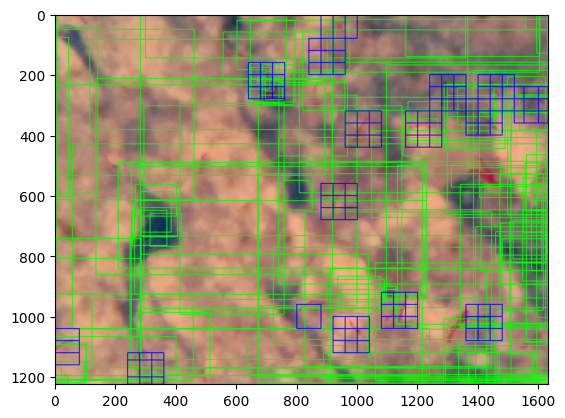

In [62]:
img = images[0].numpy()
target = targets[0]
# rescale image to 0-255 and convert to uint8
img = (img - img.min())/(img.max() - img.min())*255
img = img.astype(np.uint8).swapaxes(0,2).swapaxes(0,1)
for box, label in zip(preds['boxes'], preds['labels']):
    box = box.numpy().astype(np.int32)
    if label==1:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
    else:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255,0,0), 2)
for box, label in zip(target['boxes'], target['labels']):
    if label==0:
        continue
    box = box.numpy().astype(np.int32)
    cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,0,255), 2)
plt.imshow(img)

In [23]:
model(images, targets)   # Returns losses and detections

{'loss_classifier': tensor(0.6824, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.2534, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.7068, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.4829, grad_fn=<DivBackward0>)}

In [192]:
from src.train.fastrcnn import train_one_epoch

In [194]:
from tqdm import tqdm

num_epochs = 10
device = "cpu"

lr:float=0.005
momentum:float=0.9
weight_decay:float=0.0005
lr_scheduler_step_size:int=3
lr_scheduler_gamma:float=0.1
print_freq:int=10
checkpoint_path:str=None
checkpoint_frequency:int=1

model.to(device)
# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
# learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
# train
for epoch in tqdm(range(num_epochs)):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: [0]  [  0/100]  eta: 0:13:11  lr: 0.000055  loss: 2.1054 (2.1054)  loss_classifier: 0.7165 (0.7165)  loss_box_reg: 0.1681 (0.1681)  loss_objectness: 0.6900 (0.6900)  loss_rpn_box_reg: 0.5307 (0.5307)  time: 7.9161  data: 0.1150


In [77]:
from numba import jit
import numpy as np
from typing import Tuple

@jit(nopython=True)
def tile_coords_jitted(
    width:np.uint16, 
    height:np.uint16, 
    kernel_size:np.uint16=None, 
    stride: np.uint16=None
) -> Tuple[np.ndarray, np.uint16, np.uint16]:
    num_cols_tiles = (height // stride) + 1
    num_rows_tiles = (width // stride) + 1
    inds = np.arange(0, num_cols_tiles * num_rows_tiles, 1, np.uint16)
    x = (inds // num_cols_tiles) * stride
    y = (inds % num_cols_tiles) * stride
    num_inds = num_cols_tiles * num_rows_tiles
    coords = np.zeros((num_inds, 4), np.uint16)
    coords[:,0] = x
    coords[:,1] = y
    coords[:,2] = x + kernel_size
    coords[:,3] = y + kernel_size
    # # move coords outside the image to the edge
    x_mask = coords[:,2] >= width
    y_mask = coords[:,3] >= height
    x_shift = coords[x_mask, 2] % width
    y_shift = coords[y_mask, 3] % height
    coords[x_mask,0] = coords[x_mask,0] - x_shift
    coords[x_mask,2] = coords[x_mask,2] - x_shift
    coords[y_mask,1] = coords[y_mask,1] - y_shift
    coords[y_mask,3] = coords[y_mask,3] - y_shift
    return coords, num_cols_tiles, num_rows_tiles

def tile_coords(width:int, height:int, kernel_size:int=None, stride: int=None):
    kernel_size = (kernel_size, kernel_size)
    num_cols_tiles = (height // stride) + 1
    num_rows_tiles = (width // stride) + 1
    inds = np.arange(num_cols_tiles * num_rows_tiles)
    num_inds = num_cols_tiles * num_rows_tiles
    x = np.array((inds // num_cols_tiles) * stride)
    y = np.array((inds % num_cols_tiles) * stride)
    coords = np.zeros((num_inds, 4), np.uint16)
    coords[:,0] = x
    coords[:,1] = y
    coords[:,2] = x + kernel_size[0]
    coords[:,3] = y + kernel_size[1]
    # coords = np.stack([x, y, x + kernel_size[0], y + kernel_size[1]], axis=1)
    # move coords outside the image to the edge
    x_mask = coords[:,2] >= width
    y_mask = coords[:,3] >= height
    x_shift = coords[x_mask, [2]] % width
    y_shift = coords[y_mask, [3]] % height
    coords[x_mask,0] = coords[x_mask,0] - x_shift
    coords[x_mask,2] = coords[x_mask,2] - x_shift
    coords[y_mask,1] = coords[y_mask,1] - y_shift
    coords[y_mask,3] = coords[y_mask,3] - y_shift
    return coords

In [78]:
IMG_WIDTH = 1224
IMG_HEIGHT = 1632
KERNEL_SIZE=80
STRIDE=40


tile_coords_jitted(IMG_WIDTH, IMG_HEIGHT, KERNEL_SIZE, STRIDE)

(array([[   0,    0,   80,   80],
        [   0,   40,   80,  120],
        [   0,   80,   80,  160],
        ...,
        [1144, 1520, 1224, 1600],
        [1144, 1552, 1224, 1632],
        [1144, 1552, 1224, 1632]], dtype=uint16),
 41,
 31)

In [627]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/simon/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:06<00:00, 24.6MB/s] 


In [ ]:
model 